# Character-level Convolutional Network
In this notebook we train and evaluate the performance of a convolutional neural network in the task of detecting misinformation in WhatsApp texts.

In [1]:
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, SpatialDropout1D 
from keras.callbacks import EarlyStopping
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time, math
from utils import get_test_metrics
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline
sns.set(style="whitegrid")

Using TensorFlow backend.


## Results

In [2]:
# filepath_df = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
# df = pd.read_csv(filepath_df)

df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df_texts = pd.read_csv('data/2018/high_quality_labels/fakeWhatsApp.BR_2018_preprocessed_texts.csv')
df = pd.concat([df, df_texts], axis=1)
df.drop(columns=['Unnamed: 0'],inplace=True)

#removing duplicates and selecting only labelled data
df = df.drop_duplicates(subset=['text'])
df = df[df['midia']==0]
df['viral'] = [1 if mis==1 else vir for mis,vir in zip(df['misinformation'],df['viral'])]
df = df[df['viral']==1]

# sorting by time
def custom_time(data,hora):
    string = data + " " + hora
    return string

df['timestamp'] = df.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.sort_values(by='timestamp',inplace=True)
df.reset_index(drop=True,inplace=True)
    
df

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,...,characters,words,viral,shares,text,misinformation,preprocessed_text,preprocessed_text_stemmed,preprocessed_text_lemma,timestamp
0,6942577183305588053,02/07/18,10:46,55,BRASIL,BRA,91,Pará,2018_10,0,...,4099,634,1,1,"O dia em que ex-guerrilheiro, militantes e des...",1,"dia ex - guerrilheiro , militantes desarmament...","dia ex - guerrilh , milit desarmament tent ""fu...","dia ex - guerrilheiro , militante desarmamenti...",2018-07-02 10:46:00
1,-2072140886659020977,02/07/18,10:50,55,BRASIL,BRA,67,Mato Grosso do Sul,2018_14,0,...,247,40,1,3,O nível dos jornalistas do programa Roda Viva ...,1,nivel jornalistas programa roda viva tao baixo...,nivel jornal program rod viv tao baix ate marc...,nivel jornalista programarr rodar vivo tao bai...,2018-07-02 10:50:00
2,-5100443702615645928,02/07/18,11:03,55,BRASIL,BRA,21,Rio de Janeiro,2018_59,0,...,1192,164,1,2,*Atenção*\n\nPrecisamos da ajuda de todos você...,0,* atencao * \n \n precisamos ajuda todos voces...,* atenca * \n \n precis ajud tod voc * mant av...,* atencao * \n \n precisar ajudar todo voces *...,2018-07-02 11:03:00
3,-1561843698204261697,02/07/18,16:32,55,BRASIL,BRA,63,Tocantins,2018_20,0,...,177,31,1,5,"Gestão do colombiano na capital, imagina ele n...",1,"gestao colombiano capital , imagina governo , ...","gesta colombi capit , imagin govern , grac deu...","gestao colombiano capital , imaginar governar ...",2018-07-02 16:32:00
4,-5876784761398352499,02/07/18,18:09,55,BRASIL,BRA,61,Distrito Federal,2018_20,0,...,122,17,1,2,🛑🛑🛑🛑🛑🛑\nInterrompendo momentaneamente a conver...,1,🛑 🛑 🛑 🛑 🛑 🛑 \n interrompendo momentaneamente c...,"🛑 🛑 🛑 🛑 🛑 🛑 \n interromp momentane convers , n...",🛑 🛑 🛑 🛑 🛑 🛑 \n interromper momentaneamente con...,2018-07-02 18:09:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6382,657760642306071754,28/10/18,22:19,55,BRASIL,BRA,63,Tocantins,2018_8,0,...,68,12,1,2,Alguem tirou fotos do boletim de urna? Podem ...,1,alguem tirou fotos boletim urna ? podem enviar...,algu tir fot boletim urn ? pod envi mim ? grat,alguem tirar foto boletim urna ? poder enviar ...,2018-10-28 22:19:00
6383,3795679520023557695,28/10/18,22:25,55,BRASIL,BRA,62,Goiás,2018_22,0,...,49,8,1,2,Em frente a polícia federal... Dormitório do Lula,0,frente policia federal . . . dormitorio lula,frent polic feder . . . dormitori lul,frente policiar federal . . . dormitorio lula,2018-10-28 22:25:00
6384,-8367817193562665179,28/10/18,23:03,55,BRASIL,BRA,63,Tocantins,2018_17,0,...,60,12,1,2,"Vence a Democracia, Acima de tudo! 🙌\n*Boa Sem...",0,"vence democracia , acima tudo ! 🙌 \n * boa sem...","venc democrac , acim tud ! 🙌 \n * boa seman to...","vencer democracia , acima tudo ! 🙌 \n * bom se...",2018-10-28 23:03:00
6385,-2345811543631484060,28/10/18,23:03,?,?,?,?,?,2018_4,0,...,50,9,1,2,Se alguém aí quiser sair pra facilitar eu agra...,0,alguem ai quiser sair pra facilitar agradeco,algu ai quis sair pra facil agradec,alguem ai querer sair pra facilitar agradeco,2018-10-28 23:03:00


In [3]:
# select data
#texts
texts = df['preprocessed_lemma_text']
#target
y = df['misinformation']

In [4]:
# cut index
cut = math.floor(len(df)*0.8)
cut

5109

In [5]:
print(len(y[0:cut]))
print(len(y[cut:]))
print('{a:.2f}'.format(a = len(y[0:cut])/len(y)))
print('{a:.2f}'.format(a = len(y[cut:])/len(y)))

5109
1278
0.80
0.20


data balance in dataset


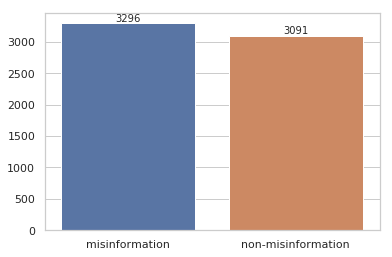

In [6]:
def print_class_balance(y):
    pos_mask = y == 1 
    pos = y[pos_mask]
    neg_mask = y == 0 
    neg = y[neg_mask]
    values = [pos.shape[0],neg.shape[0]]
    keys = ['misinformation', 'non-misinformation']
    g = sns.barplot(x = keys, y = values)
    for p in g.patches:
        g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                                   p.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, 5), textcoords = 'offset points')
print('data balance in dataset')        
print_class_balance(y)

# Char vocabulary, encoding and decoding

In [8]:
txt_list = list(texts)
#txt_list = [t for t in txt_list]
    
txt_str = " ".join(txt_list)
word_list = txt_str.split()
char_list = list(txt_str)
vocab_set = set(word_list)
features = len(vocab_set)
print(features)

59490


In [21]:
#print(list(vocab_set))

In [9]:
#dictionaries to encode char to indexes and indexes to char
char2Code = {}
code2Char = {0: ''}

i=1
for char in list(vocab_set):
    char2Code[char] = i
    code2Char[i] = char
    i+=1

In [10]:
#enconding and decoding fu
def vectorize(text, char2Code = char2Code):
    '''
    Enconding function: converts an string in code
    Input: string
    Output: coded string
    '''
    #text = text.lower()
    text_list = list(text)
    text_vector = []
    for token in text_list:
        if token in char2Code:
            code = char2Code[token]
            text_vector.append(code)
        else:
            text_vector.append(0)
    return(text_vector)

def unvectorize(vec, code2Char = code2Char):
    '''
    Decoding function: converts code in string
    Input: coded index list
    Output: string
    '''
    text = ''
    for i in vec:
        text += code2Char[i]
    return text
        
v = vectorize(('This is a test!!! Gotcha? 🌝'))
w = unvectorize(v)
print(v)
print(w)

[24924, 18945, 30610, 55183, 0, 30610, 55183, 0, 28474, 0, 48343, 18987, 55183, 48343, 17441, 17441, 17441, 0, 10290, 37505, 48343, 7505, 18945, 28474, 41866, 0, 0]
Thisisatest!!!Gotcha?


In [11]:
X = np.array([(vectorize(x)) for x in texts])

# Distribuition of chars in documents

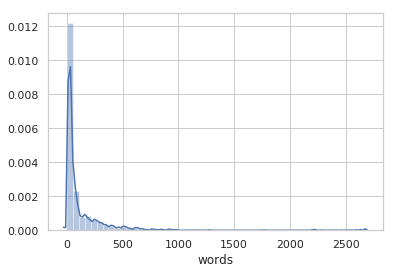

In [12]:
sns.distplot(df['words'])

In [13]:
df['words'].describe()

count    6387.000000
mean      104.681541
std       201.629622
min         1.000000
25%        15.000000
50%        30.000000
75%        93.000000
max      2664.000000
Name: words, dtype: float64

In [14]:
#pad sequences that are bigger than maxlen
maxlen = 1000
X = sequence.pad_sequences(X, maxlen=maxlen)
print(X.shape)

(6387, 1000)


# Train-test split and oversampling

In [15]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

# split by time
X_train = X[0:cut]
y_train= y[0:cut]
X_test = X[cut:]
y_test = y[cut:]

train


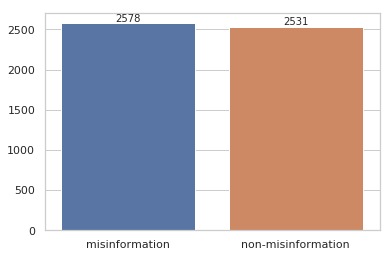

In [16]:
print('train')
print_class_balance(y_train)

test


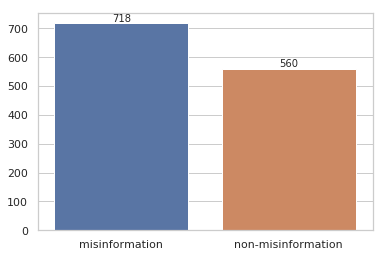

In [17]:
print('test')
print_class_balance(y_test)

In [18]:
X_train.shape

(5109, 1000)

# Balancing

In [19]:
# random oversampling
# ros = RandomOverSampler(random_state=42)
# X_train, y_train = ros.fit_resample(X_train, y_train)
# vocab_size = X_train.shape[1]    
# X_train.shape

# Build model

In [36]:
#hyperparameters:
max_features = features #726 #196921 #corrigir
batch_size = 64
embedding_dims = 100
filters = 150
kernel_size = 5
hidden_dims = 100
epochs = 20

In [37]:
# model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(13, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

In [38]:
# if 'lstm' in experiment:
#     print('Build model...')
#     model = Sequential()

#     # we start off with an efficient embedding layer which maps
#     # our vocab indices into embedding_dims dimensions

#     #variar
#     model.add(Embedding(max_features,
#                         embedding_dims,
#                         input_length=maxlen))
#     model.add(SpatialDropout1D(0.2))
#     model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#     # We project onto a single unit output layer, and squash it with a sigmoid:
#     model.add(Dense(1, activation='sigmoid'))
#     #model.add(Activation('sigmoid'))
#     model.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])
#     print(model.summary())

In [39]:
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions

#variar
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 100)         5949000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 991, 150)          150150    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 100)               0     

In [40]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_acc', patience=5, 
                                             min_delta=0.001,restore_best_weights= True)])

Train on 4598 samples, validate on 511 samples
Epoch 1/20
4598/4598 [==============================] - 96s 21ms/step - loss: 0.6248 - acc: 0.6551 - val_loss: 0.5920 - val_acc: 0.6556
Epoch 2/20
4598/4598 [==============================] - 77s 17ms/step - loss: 0.5461 - acc: 0.7184 - val_loss: 0.5574 - val_acc: 0.7241
Epoch 3/20
4598/4598 [==============================] - 79s 17ms/step - loss: 0.4886 - acc: 0.7590 - val_loss: 0.5343 - val_acc: 0.7358
Epoch 4/20
4598/4598 [==============================] - 77s 17ms/step - loss: 0.4177 - acc: 0.8123 - val_loss: 0.5045 - val_acc: 0.7436
Epoch 5/20
4598/4598 [==============================] - 83s 18ms/step - loss: 0.3496 - acc: 0.8545 - val_loss: 0.4867 - val_acc: 0.7613
Epoch 6/20
4598/4598 [==============================] - 85s 18ms/step - loss: 0.3038 - acc: 0.8723 - val_loss: 0.4882 - val_acc: 0.7593
Epoch 7/20
4598/4598 [==============================] - 85s 19ms/step - loss: 0.2165 - acc: 0.9250 - val_loss: 0.5106 - val_acc: 0.7710
E

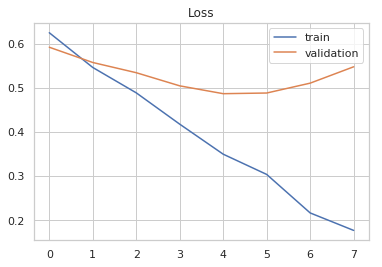

In [41]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show();

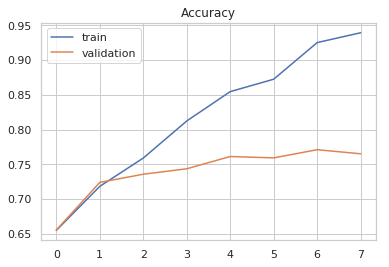

In [42]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.show();

In [43]:
y_prob = model.predict(X_test)
y_prob_train = model.predict(X_train)

In [44]:
def optimal_threshold(prob,y):
    best_thresold = 0
    best_score = 0
    
    for i in range(100):
        threshold = i/100
        y_pred = [1 if p >= threshold else 0 for p in prob]
        score = metrics.accuracy_score(y,y_pred)
        
        if score > best_score:
            #print(score)
            best_thresold = threshold
            best_score = score
            
    return best_thresold

threshold = optimal_threshold(y_prob_train,y_train)
print(threshold)

0.68


              precision    recall  f1-score   support

           0       0.65      0.77      0.71       560
           1       0.79      0.68      0.73       718

    accuracy                           0.72      1278
   macro avg       0.72      0.72      0.72      1278
weighted avg       0.73      0.72      0.72      1278

AUC:  0.8027643752487068


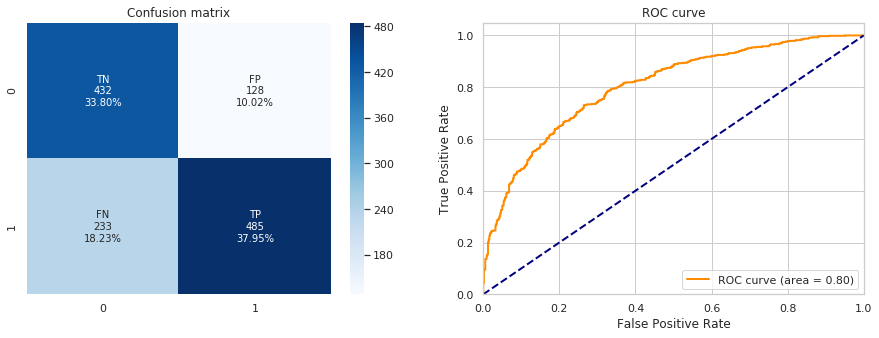

In [45]:
y_pred = [0 if x <= threshold else 1 for x in y_prob]
acc, precision, recall, f1, roc_auc = get_test_metrics(y_test, y_pred, y_prob)

# Errors examples

In [58]:
full_texts_train, full_texts_test, yf_train, yf_test = train_test_split(texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

In [59]:
# 1-1 = 0 true positive
# 0-0 = 0 true negative
# 1-0 = 1 false negative
# 0-1 = -1 false positive
y_fails = y_test - y_pred
FN = [index for index, value in enumerate(y_fails) if value == 1]
FP = [index for index, value in enumerate(y_fails) if value == -1]

print('Total test data:', len(y_pred))
print('False negative: ',len(FN))
print('False positive: ',len(FP))

Total test data: 1057
False negative:  150
False positive:  86


In [60]:
full_texts_test = list(full_texts_test)
texts_FN = [full_texts_test[fn] for fn in FN]
texts_FP = [full_texts_test[fp] for fp in FP]

## False negative

In [61]:
for fn in texts_FN:
    print()
    print('***')
    print(fn)
    print('***')
    print()


***
Gente Apenas Minha Opinião então Vamos lá

No Dia 06 de Junho TSE Derruba o Voto Impresso de Autoria do deputado Federal Candidato a presidente Jair Bolsonaro

No Dia 06 de Setembro Jair Bolsonaro Sofre um Atentado que Seria pra MATAR

Um Dia Antes da Eleição Dia 06; Coincidência Se Juntar as Datas dar Certos 666 
Agora Bolsonaro corre novo Risco...

A que Interessa Isso ? Nova Ordem Mundial / Marconaria ? / iluminati ? / 
Peço que Compartilhem 
E Faca Chegar ao Bolsonaro

Breno Washington MG
Juntos somos fortes
***


***
Testemunho altamente confiável do meu amigo Dante Mantovani! Muito obrigado pelo texto tão esclarecedor e desmistificador, meu amigo: 

Após ter acompanhado Jair Bolsonaro pelo interior de SP por quatro cidades (Presidente Prudente, Araçatuba, Glicério e São José do Rio Preto), divido com vocês o que percebi até aqui:

1-)ao contrário do estereótipo que a mídia criou e que impõe goela abaixo ao seu público, a personalidade de Jair Bolsonaro é tremendamente afável

## False positive

In [62]:
for fp in texts_FP:
    print()
    print('***')
    print(fp)
    print('***')
    print()


***
TEXTO DA FUNDADORA DO DIRETÓRIO DO PT EM ARACAJU

Esquerda brasileira, chega de apontar culpados! Está na hora de assumir o ocorrido e partir prum mea culpa já!, antes que os Dórias e Bolssonaros assumam o poder! Quem elegeu Temer não foram os coxinhas. Parem de tergiversar. Temer foi eleito por vocês com dinheiro público desviado de hospitais, creches e escolas! O resto é retórica, ou ilação como vocês agora costumam chamar o que nós brasileiros conhecemos como mentira!

A arrogância da esquerda de acreditar que lida com tolos e que porta o Santo Graal está no pano de fundo de sua derrocada mundo afora.

Vamos fazer diferente e lavar a jato essa roupa suja antes que seja tarde! A máscara caiu!

Um homem que responsabiliza a companheira morta para não assumir seus atos é um covarde e não herói . Essa inversão de valores para mim é assustadora...

E não me venham falar da corrupção que existe desde a época de CABRAL que não somos trouxinhas...Nós militamos no PT e construímos esse 